# Part 2

So, what is it about Carly Rae Jepsen that led me to listen to her sizably more than any other artist. Luckily, Spotify has an API that can give us a features to work with.

To query data from the Spotify API, I'm going to use a library called Spotipy that does a lot of the server side work for us and wraps them in neat function calls.

In [1]:
import secret
import spotipy

from spotipy.oauth2 import SpotifyClientCredentials
cid = secret.client_id
secret = secret.client_secret
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

Gotta import the data again

In [2]:
import pandas as pd

df_data = pd.read_json("../streaming_histories/one_year_streaming_history0.json")
df_data['endTime'] = pd.to_datetime(df_data['endTime']) 
df_data.head()

,endTime,artistName,trackName,msPlayed
0,2019-01-05 05:32:00,Tonight Alive,World Away,0
1,2019-01-05 05:36:00,Eminem,Greatest,226937
2,2019-01-05 05:40:00,Elephante,Sirens,249411
3,2019-01-05 05:45:00,Mike Williams,Bambini,2972
4,2019-01-05 05:45:00,Panic! At The Disco,High Hopes,190946


In [3]:
df_data.shape

(6502, 4)

There's quite a lot of songs in this data, but many are duplicates. Thus I'll group them together and sum the amount of time I listened to those songs.

In [4]:
df_by_song = df_data.groupby([df_data['trackName'], df_data['artistName']]).sum().reset_index()
df_by_song.head()

,trackName,artistName,msPlayed
0,!!!!!!!,Billie Eilish,13578
1,&burn (with Vince Staples),Billie Eilish,358030
2,*Sobs Quietly*,Mom Jeans.,118464
3,10 Feet Down,NF,16958
4,"10,000 Hours (with Justin Bieber)",Dan + Shay,2012316


There's over 1200 songs in that list, but I'm only interested in comparing the songs that I actually liked to those of CRJ that I liked. To select these, I'm only going to select songs that I listened to more than 5 times. I decided on 5 times because that is where I started to see songs that I recognized as ones that I liked. 

This is calculated by assuming the average songs length is ~3 minutes (180000ms) and multiplying that by 5.

I'm doing this before querying from the API to keep my usage down.

In [5]:
songs_liked = df_by_song.loc[df_by_song['msPlayed'] > (180000 * 5)].sort_values(by='msPlayed', ascending=False).reset_index(drop=True)
songs_liked

,trackName,artistName,msPlayed
0,America Online,The Midnight,13237685
1,Until the End of Time,For The Win,12448580
2,The Search,NF,11221608
3,Takeaway (feat. Lennon Stella),The Chainsmokers,11122297
4,BLOW (with Chris Stapleton & Bruno Mars),Ed Sheeran,11059797
...,...,...,...
186,Gold,Kiiara,1132086
187,Rebel Girl,Angels & Airwaves,1130035
188,I'm Not Racist,Joyner Lucas,1127251
189,Goodbyes (feat. Young Thug),Post Malone,1049118


Brings us down to a healthy 191 songs.

Next, I'm going to query from Spotify's API. Here I'm only getting the uri (so that I can get more advanced data later), the popularity of the song, and the length of the song which I will use to calculate the number of times I played that song.

In [6]:
import numpy as np
songs_liked['uri'] = ""
songs_liked['popularity'] = np.nan
songs_liked['songLengthMs'] = np.nan
songs_liked['timesPlayed'] = np.nan


for idx, row in songs_liked.iterrows():
    results = sp.search(q='artist:{} track:{}'.format(
        songs_liked['artistName'][idx].lower(),
        songs_liked['trackName'][idx][:8].lower(), type='track'))

    try:
        uri = results['tracks']['items'][0]['uri'].split(':')[2]
        popularity = results['tracks']['items'][0]['popularity']
        song_length = results['tracks']['items'][0]['duration_ms']
        times_played = round(songs_liked['msPlayed'][idx] / song_length, 2)
    except:
        IndexError

    songs_liked.at[idx, 'uri'] = uri
    songs_liked.at[idx, 'popularity'] = popularity
    songs_liked.at[idx, 'songLengthMs'] = song_length
    songs_liked.at[idx, 'timesPlayed'] = times_played

songs_liked

,trackName,artistName,msPlayed,uri,popularity,songLengthMs,timesPlayed
0,America Online,The Midnight,13237685,1BU1WTFvnrXpgooJRMlWiW,55.0,349706.0,37.85
1,Until the End of Time,For The Win,12448580,4XcmsnRjjCECEqJvsbH0ot,36.0,272730.0,45.64
2,The Search,NF,11221608,2OKo7g3KfmCt3kyLvUAL0g,74.0,248040.0,45.24
3,Takeaway (feat. Lennon Stella),The Chainsmokers,11122297,3g0mEQx3NTanacLseoP0Gw,83.0,209880.0,52.99
4,BLOW (with Chris Stapleton & Bruno Mars),Ed Sheeran,11059797,6EbduYTr62sSzvl36wWiFM,70.0,209120.0,52.89
...,...,...,...,...,...,...,...
186,Gold,Kiiara,1132086,6ZSO7kPn8IMJFymyticbJO,69.0,225882.0,5.01
187,Rebel Girl,Angels & Airwaves,1130035,1EEt3kxO1yZSZd13DqvT8f,54.0,226007.0,5.00
188,I'm Not Racist,Joyner Lucas,1127251,1EEt3kxO1yZSZd13DqvT8f,54.0,226007.0,5.00
189,Goodbyes (feat. Young Thug),Post Malone,1049118,0t3ZvGKlmYmVsDzBJAXK8C,84.0,174853.0,6.00


Now we can get the interesting features of the songs

In [7]:
def get_features_of_songs():
    i = 0
    info_list = []
    for idx, row in songs_liked.iterrows():
        result = sp.audio_features(row['uri'])
        result = result[0]

        info_list.append([
            result['danceability'], 
            result['energy'],
            result['key'],
            result['loudness'],
            result['mode'],
            result['speechiness'],
            result['acousticness'],
            result['liveness'],
            result['valence'],
            result['tempo']])

        song_data = pd.DataFrame(info_list)
        song_data.columns = [
            'danceability',
            'energy',
            'key',
            'loudness',
            'mode',
            'speechiness',
            'acousticness',
            'liveness',
            'valence',
            'tempo']

    return(song_data)

In [8]:
song_data = get_features_of_songs()
song_data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo
0,0.621,0.641,2,-10.894,1,0.0440,0.010100,0.2470,0.0776,101.973
1,0.526,0.663,0,-4.364,1,0.0362,0.345000,0.0567,0.4090,130.227
2,0.789,0.786,2,-4.788,1,0.2970,0.596000,0.0997,0.3900,119.957
3,0.528,0.511,3,-8.144,1,0.0324,0.126000,0.1010,0.3510,100.100
4,0.631,0.796,1,-5.350,1,0.0401,0.000245,0.3800,0.5960,92.469


Let's slap these bad boys together.

In [9]:
songs_liked_with_data = pd.concat([songs_liked, song_data], axis=1)
songs_liked_with_data.head()

,trackName,artistName,msPlayed,uri,popularity,songLengthMs,timesPlayed,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo
0,America Online,The Midnight,13237685,1BU1WTFvnrXpgooJRMlWiW,55.0,349706.0,37.85,0.621,0.641,2,-10.894,1,0.0440,0.010100,0.2470,0.0776,101.973
1,Until the End of Time,For The Win,12448580,4XcmsnRjjCECEqJvsbH0ot,36.0,272730.0,45.64,0.526,0.663,0,-4.364,1,0.0362,0.345000,0.0567,0.4090,130.227
2,The Search,NF,11221608,2OKo7g3KfmCt3kyLvUAL0g,74.0,248040.0,45.24,0.789,0.786,2,-4.788,1,0.2970,0.596000,0.0997,0.3900,119.957
3,Takeaway (feat. Lennon Stella),The Chainsmokers,11122297,3g0mEQx3NTanacLseoP0Gw,83.0,209880.0,52.99,0.528,0.511,3,-8.144,1,0.0324,0.126000,0.1010,0.3510,100.100
4,BLOW (with Chris Stapleton & Bruno Mars),Ed Sheeran,11059797,6EbduYTr62sSzvl36wWiFM,70.0,209120.0,52.89,0.631,0.796,1,-5.350,1,0.0401,0.000245,0.3800,0.5960,92.469


And __BAM__ we got ourselves a dataset with all the data we'll need

Let's take a quick look at how our features are correlated

<AxesSubplot:>

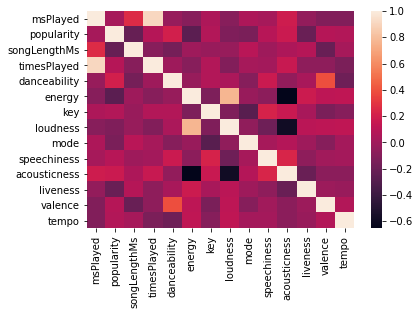

In [10]:
import seaborn as sns

corr = songs_liked_with_data.corr()
sns.heatmap(corr)

Not a whole lot of clarity revealed here. Naturally, loudness and energy are fairly highly correlated. Danceability and valence is interesting. Valence is a measure of musical positity (you can read more [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)). It somewhat makes sense that danceability would be correlated with positity. Perhaps more exploration with a larger dataset of songs could reveal truly how positive danceable songs are. Energy and acousticness being negatively correlated makes sense. Same with acousticness and loudness. Unfortunately, no glaring strong correlations with timesPlayed. 

Next, I'm going to split this dataset into songs by Carly Rae Jepsen and songs that are not.

In [11]:
carly = songs_liked_with_data[songs_liked_with_data['artistName'] == 'Carly Rae Jepsen'].reset_index(drop=True)
non_carly = songs_liked_with_data[songs_liked_with_data['artistName'] != 'Carly Rae Jepsen'].reset_index(drop=True)

In [12]:
print(carly.shape)
print(non_carly.shape)

(18, 17)
(173, 17)


And then immediately slap them back together

In [13]:
concatenated = pd.concat([carly.assign(dataset='carly'), non_carly.assign(dataset='non_carly')])

"_Well why'd you do that?_"

Because I need to plot them together, but need a good way to distinguish them. The plan here is to boxplot the features and then compare the means of the plots to see what _on average_ makes me like Carly Rae Jepsen more

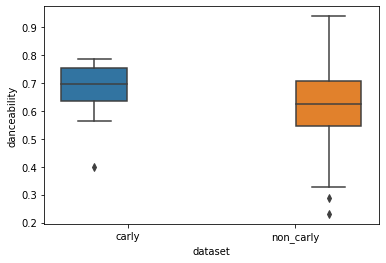

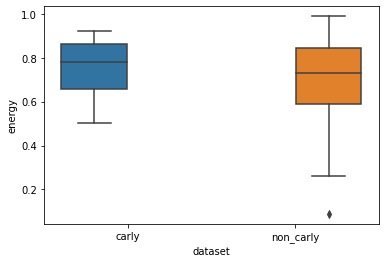

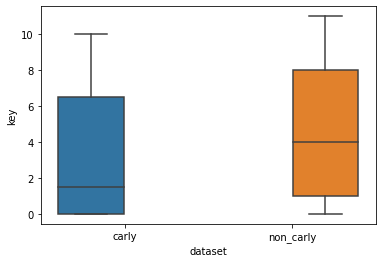

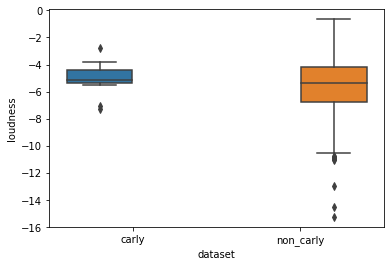

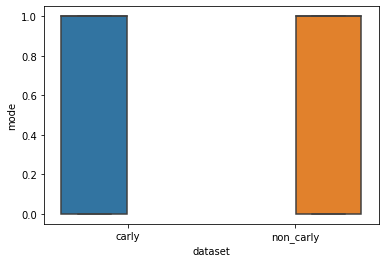

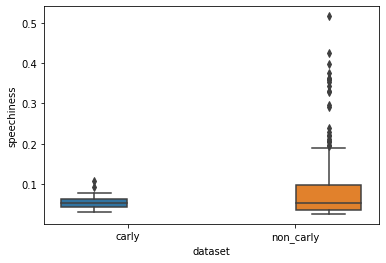

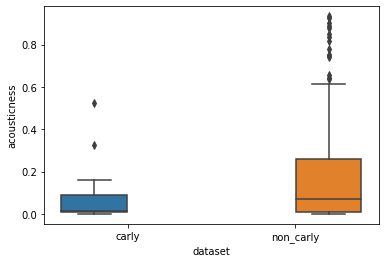

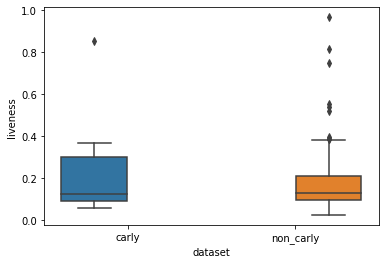

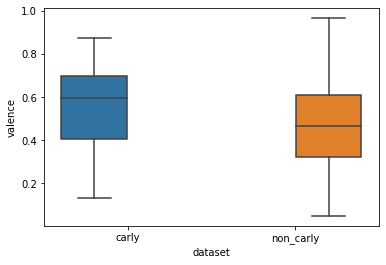

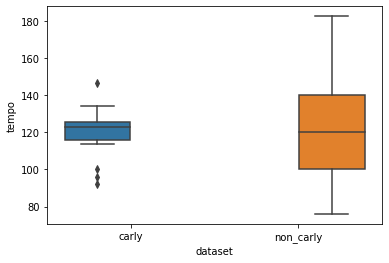

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

of_interest=['popularity', 'songLengthMs', 'timesPlayed', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo']

for i in range(3, len(of_interest)):
    plt.figure()
    g = sns.boxplot(data=concatenated, x='dataset', y=of_interest[i], hue='dataset')
    g.legend_.remove()

    plt.show()

In [15]:
# major == 1 minor == 0
ratio_maj_min_carly = len(carly[carly['mode'] == 1]) / len(carly[carly['mode'] == 0])
ratio_maj_min_non_carly = len(non_carly[non_carly['mode'] == 1]) / len(non_carly[non_carly['mode'] == 0]) 
print("Ratio of songs in a major key vs a minor key (CRJ):", ratio_maj_min_carly)
print("Ratio of songs in a major key vs a minor key (everything else):", ratio_maj_min_non_carly)

Ratio of songs in a major key vs a minor key (CRJ): 2.0
Ratio of songs in a major key vs a minor key (everything else): 1.7903225806451613


And it looks like the features that make Carly different from the rest of my music is 

* her songs are higher tempo
* her songs are higher valence (musical positivity)
* her songs are less acoustic 
* her songs are louder
* her songs have higher energy
* her songs are more danceable
* her songs are more often in a major key

So now I want to see whether those features inform how much I liked non-CRJ songs. To do this, I'm going to make a couple radar/spider charts and look at how my top CRJ and non-CRJ songs appear in that representation. 

My choice for spider/radar charts is that it's more likely that the __combination__ of features in CRJ songs is what I like rather than just the individual features.

But first we need to adjust the data such that they are in an appropriate range



In [69]:
from sklearn import preprocessing

loud_scaler = preprocessing.MinMaxScaler()
tempo_scaler = preprocessing.MinMaxScaler()
length_scaler = preprocessing.MinMaxScaler()
songs_liked_scaled = songs_liked_with_data.copy().sort_values(by='timesPlayed', ascending=False).reset_index(drop=True)
songs_liked_scaled['loudness'] = loud_scaler.fit_transform(songs_liked_with_data[['loudness']])
songs_liked_scaled['tempo'] = tempo_scaler.fit_transform(songs_liked_with_data[['tempo']])
songs_liked_scaled['songLengthMs'] = length_scaler.fit_transform(songs_liked_with_data[['songLengthMs']])
songs_liked_scaled['popularity'] = songs_liked_scaled['popularity'].apply(lambda x: x / 100) #popularity ranges from 0 to 100
songs_liked_scaled['key'] = songs_liked_scaled['key'].apply(lambda x: x / 12) # there are 12 pitch classes
songs_liked_scaled.head()

,trackName,artistName,msPlayed,uri,popularity,songLengthMs,timesPlayed,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo
0,Derezzed - Remixed by Avicii,Daft Punk,6686806,5X4ojuZG2mZ68EcLyBQ1D3,0.58,0.825496,64.22,0.540,0.635,0.083333,0.299904,1,0.0519,0.001660,0.2090,0.126,0.243762
1,Takeaway (feat. Lennon Stella),The Chainsmokers,11122297,3g0mEQx3NTanacLseoP0Gw,0.83,0.566754,52.99,0.528,0.511,0.250000,0.746614,1,0.0324,0.126000,0.1010,0.351,0.509504
2,BLOW (with Chris Stapleton & Bruno Mars),Ed Sheeran,11059797,6EbduYTr62sSzvl36wWiFM,0.70,0.483763,52.89,0.631,0.796,0.083333,0.717608,1,0.0401,0.000245,0.3800,0.596,0.412910
3,South of the Border (feat. Camila Cabello & Ca...,Ed Sheeran,10718208,4vUmTMuQqjdnvlZmAH61Qk,0.83,0.355495,52.42,0.857,0.621,0.750000,0.488028,0,0.0825,0.148000,0.0865,0.668,0.226145
4,lovely (with Khalid),Billie Eilish,10077801,0u2P5u6lvoDfwTYjAADbn4,0.89,0.352940,50.34,0.351,0.296,0.333333,0.679163,0,0.0333,0.934000,0.0950,0.120,0.154372


I'm going to start with the best piece of music ever produced: _Run Away With Me_

In [70]:
import plotly.express as px

of_interest=['trackName', 'key', 'songLengthMs', 'popularity', 'danceability', 'energy', 'loudness', 'liveness', 'valence', 'tempo', 'speechiness', 'acousticness']

run_with_me = songs_liked_scaled[songs_liked_scaled.trackName == 'Run Away With Me'][of_interest]

fig = px.line_polar(run_with_me, r=run_with_me.values[0][1:], theta=run_with_me.columns[1:])
fig.update_traces(fill='toself')
fig.show()

In [71]:
other = songs_liked_scaled[songs_liked_scaled.trackName.str.contains('Takeaway')][of_interest]

fig = px.line_polar(run_with_me, r=other.values[0][1:], theta=other.columns[1:])
fig.update_traces(fill='toself')
fig.show()

In [72]:
carly_adjusted = songs_liked_scaled[songs_liked_scaled.artistName == 'Carly Rae Jepsen'][of_interest]
carly_adjusted.head()

,trackName,key,songLengthMs,popularity,danceability,energy,loudness,liveness,valence,tempo,speechiness,acousticness
41,Cut To The Feeling,0.166667,0.506808,0.69,0.710,0.909,0.859283,0.3030,0.648,0.647191,0.0639,0.01350
81,Turn Me Up,0.583333,0.291135,0.37,0.654,0.818,0.696196,0.1750,0.548,0.507557,0.0788,0.09540
90,Run Away With Me,0.083333,0.438318,0.61,0.564,0.719,0.676290,0.0536,0.251,0.403815,0.0475,0.01260
91,Wrong Feels So Right,0.000000,0.349495,0.32,0.657,0.639,0.625120,0.3290,0.377,0.460981,0.0502,0.01410
99,Guitar String / Wedding Ring,0.333333,0.344960,0.32,0.685,0.782,0.747229,0.8540,0.730,0.450504,0.0519,0.00881


In [73]:
non_carly_adjusted = songs_liked_scaled[songs_liked_scaled.artistName != 'Carly Rae Jepsen'][of_interest]
non_carly_adjusted.head()

,trackName,key,songLengthMs,popularity,danceability,energy,loudness,liveness,valence,tempo,speechiness,acousticness
0,Derezzed - Remixed by Avicii,0.083333,0.825496,0.58,0.540,0.635,0.299904,0.2090,0.126,0.243762,0.0519,0.001660
1,Takeaway (feat. Lennon Stella),0.250000,0.566754,0.83,0.528,0.511,0.746614,0.1010,0.351,0.509504,0.0324,0.126000
2,BLOW (with Chris Stapleton & Bruno Mars),0.083333,0.483763,0.70,0.631,0.796,0.717608,0.3800,0.596,0.412910,0.0401,0.000245
3,South of the Border (feat. Camila Cabello & Ca...,0.750000,0.355495,0.83,0.857,0.621,0.488028,0.0865,0.668,0.226145,0.0825,0.148000
4,lovely (with Khalid),0.333333,0.352940,0.89,0.351,0.296,0.679163,0.0950,0.120,0.154372,0.0333,0.934000


In [74]:
carly_plot = go.Figure()

for idx, row in carly_adjusted.iterrows():
    carly_plot.add_trace(go.Scatterpolar(
      r=row.values[1:],
      theta=of_interest[1:],
      fill='toself',
      name=row.values[0]
    ))

carly_plot.update_layout(
  title = {
      'text': 'Carly Rae Jepsen Song Radar Chart',
      'xanchor': 'center',
      'yanchor': 'top',
      'x': 0.5
  },
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=False
)

carly_plot.show()

In [75]:
non_carly_plot = go.Figure()

len_carly = len(carly_adjusted)

for idx, row in non_carly_adjusted.iterrows():
    non_carly_plot.add_trace(go.Scatterpolar(
      r=row.values[1:],
      theta=of_interest[1:],
      fill='toself',
      name=row.values[0]
    ))

    if idx == len_carly:
        break

non_carly_plot.update_layout(
  title = {
      'text': 'Non-CRJ Song Radar Chart',
      'xanchor': 'center',
      'yanchor': 'top',
      'x': 0.5
  },
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=False
)

non_carly_plot.show()

In [76]:
non_carly_reversed = non_carly_adjusted.reindex(index = non_carly_adjusted.index[::-1])

least_fav_plot = go.Figure()

len_carly = len(carly_adjusted)

for idx, row in non_carly_reversed.iterrows():
    least_fav_plot.add_trace(go.Scatterpolar(
      r=row.values[1:],
      theta=of_interest[1:],
      fill='toself',
      name=row.values[0]
    ))

    if idx == len(non_carly_reversed) - len_carly:
        break

least_fav_plot.update_layout(
  title = {
      'text': 'Least Listened Non-CRJ Song Radar Chart',
      'xanchor': 'center',
      'yanchor': 'top',
      'x': 0.5
  },
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=False
)

least_fav_plot.show()

So upon examining these plots, what do we learn?

1. I very much value features of loudness, energy, danceability, popularity, high valence, and high tempo
* Note: Popularity likely has no true bearing on my liking a song i.e. it is correlated with songs that I like, but probably not the cause. This is just an intuitive guess and not necessarily confirmed by the data
2. I do not value speechiness virtually at all
3. Carly Rae Jepsen is different from the rest of my other music in that they are less acoustic-y and shorter in length
* I won't give much weight to the high liveliness oberseved in the CRJ plot as this seems to only come from one song, so it's hardly a significant finding

